In [1]:
import neurogym
import warnings
warnings.filterwarnings("ignore")  # to suppress warnings
import numpy as np
import gym
import neurogym as ngym
from neurogym import spaces
from neurogym.wrappers.block import ScheduleEnvs
from neurogym.utils import scheduler
from neurogym.core import TrialWrapper
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

# Neurogym version of multi-dimensional integration task

In [91]:
np.zeros([1] + self.dim_input * list(self.action_space.shape), )

TypeError: 'int' object is not iterable

In [107]:
np.tile(np.zeros([4]), 3)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [108]:
np.tile(np.zeros([5],), 2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [123]:
import numpy as np
import gym
import neurogym as ngym
from neurogym import spaces
from neurogym.wrappers.block import ScheduleEnvs
from neurogym.utils import scheduler
from neurogym.core import TrialWrapper
import torch
import matplotlib.pyplot as plt


def _get_dist(original_dist):
    '''Get the distance in periodic boundary conditions'''
    return np.minimum(abs(original_dist), 2 * np.pi - abs(original_dist))


def _gaussianbump(loc, theta, strength):
    dist = _get_dist(loc - theta)  # periodic boundary
    dist /= np.pi / 8
    return 0.8 * np.exp(-dist ** 2 / 2) * strength


def _cosinebump(loc, theta, strength):
    return np.cos(theta - loc) * strength / 2 + 0.5

class _MultiModalityStimulus(TrialWrapper):
    """Move observation to specific modality."""
    def __init__(self, env, modality=0, n_modality=1):
        super().__init__(env)
        self.modality = modality
        if 'stimulus' not in self.task.observation_space.name:
            raise KeyError('observation_space does not have name stimulus')
        ind_stimulus = np.array(self.task.observation_space.name['stimulus'])
        len_stimulus = len(ind_stimulus)
        ob_space = self.task.observation_space
        ob_shape = ob_space.shape[0] + (n_modality - 1) * len_stimulus
        # Shift stimulus
        name = {'fixation': 0,
                'stimulus': ind_stimulus + len_stimulus * modality
                # 'stimulus' : ind_stimulus 
        }
        self.observation_space = self.task.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(ob_shape,), dtype=ob_space.dtype, name=name)

    def new_trial(self, **kwargs):
        return self.env.new_trial(**kwargs)

class EnvWithAdditions(ngym.TrialEnv):
          
    def _init_gt(self):
        """Initialize trial with ground_truth."""
        tmax_ind = int(self._tmax / self.dt)
        self.gt = np.zeros([tmax_ind] + list(self.action_space.shape),
                           dtype=self.action_space.dtype)
        
        self._gt_built = True

    def my_set_groundtruth(self, value, period=None, where=None, seq=0):
        """Set groundtruth value."""
        if not self._gt_built:
            self._init_gt()

        if where is not None:
            # TODO: Only works for Discrete action_space, make it work for Box
            value = self.action_space.name[where][value]
        if isinstance(period, str):
          for t in range(int(self.timing['decision'] / self.dt)):
              self.gt[self.start_ind['decision'] + t] = np.mod(value +int(seq * t * self.omega * self.dt), self.dim_ring)

        elif period is None:
            self.gt[:] = value
        else:
            for p in period:
                self.my_set_groundtruth(value, p)


#Go Family
class _Reach(EnvWithAdditions):
    metadata = {
    }

    def __init__(self, dt=100, anti=True, rewards=None, timing=None,
                 dim_ring=16, dim_input=1, reaction=False, integrate=0, seq=0, dly=False):
        super().__init__(dt=dt)

        self.anti = anti
        self.reaction = reaction
        self.omega = 0.01
        #self.omega = 0.05 #angular velocity (rad/ms)
        self.integrate = integrate
        self.seq = seq
        self.dt = dt

        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 500,
            'stimulus': 500,
            'delay' : 500,
            'decision': 500}
        if not dly:
            self.timing['delay'] = 500
        if timing:
            self.timing.update(timing)

        self.abort = False

        # action and observation spaces
        self.dim_ring = dim_ring
        self.dim_input = dim_input 
        self.theta = np.arange(0, 2 * np.pi, 2 * np.pi / dim_ring)
        self.choices = np.arange(dim_ring)

        name = {'fixation': 0, 'stimulus': range(1, dim_input * dim_ring + 1)}
        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(1 + dim_input * dim_ring,), dtype=np.float32, name=name)

        name = {'fixation': 0, 'choice': range(1, dim_input * dim_ring + 1)}
        self.action_space = spaces.Discrete(1 + dim_input * dim_ring, name=name)

    def _new_trial(self, **kwargs):
      
        # Trial info
        trial = {
            'ground_truth': [self.rng.choice(self.choices) for _ in range(self.dim_input)],
            'anti': self.anti,
            'integrate': self.integrate,
            'seq': self.seq
        }

        trial.update(kwargs)
        if trial['integrate']:
            self.timing['delay'] = int(np.random.choice(np.arange(0,1200,100)))

        # need to put into a for loop over input in range(dim_input)
        stim = np.zeros((self.dim_input * self.dim_ring, ))
        for i in range(self.dim_input):
            ground_truth = trial['ground_truth'][i]
            stim_theta = np.mod(self.theta[ground_truth] + int(trial['integrate']) * self.omega * self.timing['delay'] + int(trial['anti'])*np.pi, 2*np.pi)
            stim_this_input = _gaussianbump(stim_theta, self.theta, 1)
            stim[i * self.dim_ring : (i + 1) * self.dim_ring] = stim_this_input
            
        if not self.reaction:
            periods = ['fixation', 'stimulus', 'delay', 'decision']
            self.add_period(periods)

            self.add_ob(1, period=['fixation', 'stimulus', 'delay'], where='fixation')
            self.add_ob(stim, period='stimulus', where='stimulus')
        
        else:
            periods = ['fixation', 'decision']
            self.add_period(periods)

            self.add_ob(1, period='fixation', where='fixation')
            self.add_ob(stim, period='decision', where='stimulus')

        self.my_set_groundtruth(value=ground_truth, period='decision', where='choice', seq=self.seq)

        # # set truth 
        # tmax_ind = int(self._tmax / self.dt)
        # self.gt = np.tile(np.zeros([tmax_ind] + list(self.action_space.shape),
        #                    dtype=self.action_space.dtype), self.dim_input)
        
        # # gt = np.zeros((self.dim_input * self.dim_ring, ))
        # for i in range(self.dim_input):
        #     ground_truth = trial['ground_truth'][i]
        #     gt_this_input = 
        #     for t in range(int(self.timing['decision'] / self.dt)):
        #       self.gt[self.start_ind['decision'] + t] = np.mod(ground_truth +int(self.seq * t * self.omega * self.dt), self.dim_ring)


        #     gt[i * self.dim_ring : (i + 1) * self.dim_ring] = ground_truth
        # self.gt = gt


        return trial


    def _step(self, action):
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}


# Go family tasks
def _reach(**kwargs):
    # envs = list()
    # num_inputs = kwargs['dim_input']
    # for modality in [0,1]:
    #     env = _Reach(**kwargs)
    #     env = _MultiModalityStimulus(env, modality=modality, n_modality=2)
    #     envs.append(env)

    # schedule = scheduler.RandomSchedule(len(envs))
    envs = list()
    env = _Reach(**kwargs)
    envs.append(env)
    schedule = scheduler.RandomSchedule(len(envs))
    env = ScheduleEnvs(envs, schedule, env_input=False)
    return env

def go_1(**kwargs):
    env_kwargs = kwargs.copy()
    env_kwargs['anti'] = False
    env_kwargs['dim_input'] = 1
    return _reach(**env_kwargs)

def go_2(**kwargs):
    env_kwargs = kwargs.copy()
    env_kwargs['anti'] = False
    env_kwargs['dim_input'] = 2
    return _reach(**env_kwargs)


def multidim_go(**kwargs):
    env_kwargs = kwargs.copy()
    env_kwargs['anti'] = False
    env_kwargs['dim_input'] = 2
    return _reach(**env_kwargs)

def dlygo(**kwargs):
    env_kwargs = kwargs.copy()
    env_kwargs['anti'] = False
    env_kwargs['dly'] = True
    return _reach(**env_kwargs)

def dlygointr(**kwargs):
    env_kwargs = kwargs.copy()
    env_kwargs['anti'] = False
    env_kwargs['integrate'] = 1
    env_kwargs['dly'] = True
    return _reach(**env_kwargs)

In [4]:
from neurogym.utils.scheduler import SequentialSchedule
import matplotlib.pyplot as plt
import numpy as np

In [80]:
np.zeros([4])

array([0., 0., 0., 0.])

In [121]:
dir(envs[0].action_space)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 '_np_random',
 '_shape',
 'contains',
 'dtype',
 'from_jsonable',
 'is_np_flattenable',
 'n',
 'name',
 'np_random',
 'sample',
 'seed',
 'shape',
 'start',
 'to_jsonable']

In [124]:
schedule = SequentialSchedule(1)
#choose your favorite mod-cog task to test
# envs = [dlygointr()]
# envs = [go_1()]
envs = [go_2()]
# envs = [dlyctxrot1_2ring()]
env = ScheduleEnvs(envs, schedule=schedule, env_input=False)
dataset = ngym.Dataset(env, batch_size=1, seq_len=60)

inputs, outputs = dataset()
# plt.figure(figsize = (30,50))

# plt.imshow(inputs[:,0,1:33].T) #inputs[:,0,>33] are the rule inputs
# plt.plot(outputs,'w',lw=2)

In [125]:
inputs.shape

(60, 1, 33)

In [126]:
outputs.shape

(60, 1)

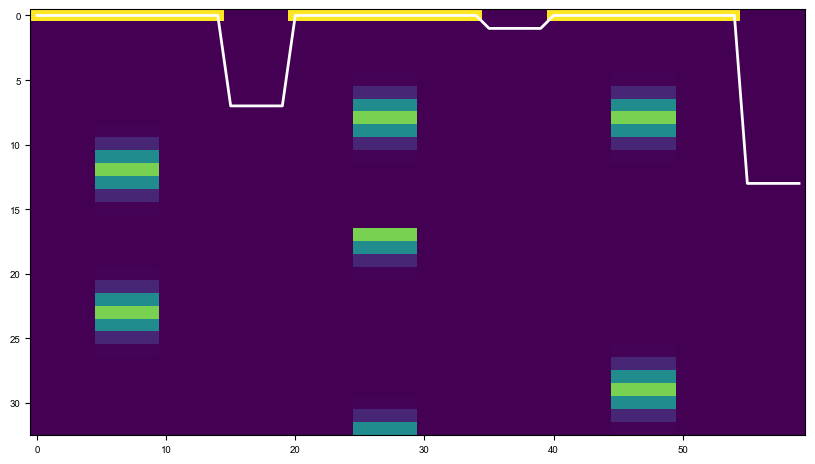

In [129]:
plt.figure(figsize = (10,10))
plt.imshow(inputs[:, 0, :].T)
plt.plot(outputs, 'w', lw=2)

In [97]:
bump_loc_1 = [np.argmax(inputs[t, 0, 1:16+1]) for t in range(inputs.shape[0])]
bump_loc_2 = [np.argmax(inputs[t, 0, 17:32+1]) for t in range(inputs.shape[0])]

In [70]:
outputs.shape

(60, 1)

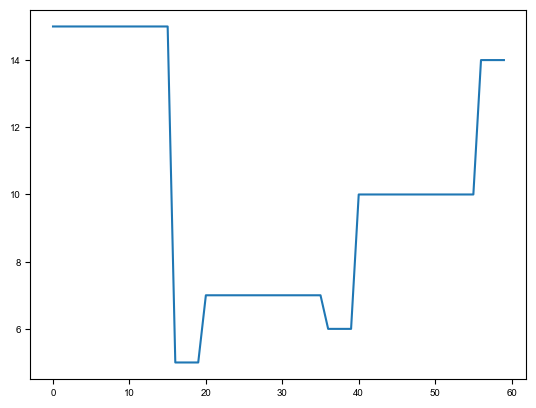

In [98]:
plt.plot(outputs)

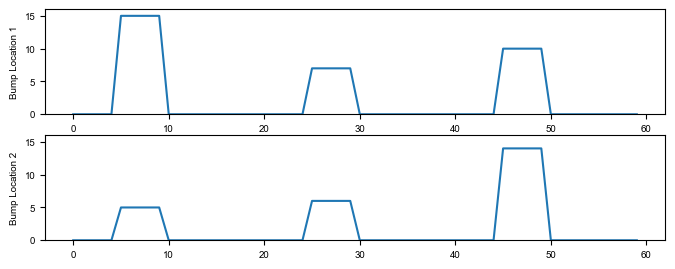

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3))

ax1.plot(bump_loc_1)
ax1.set_ylabel('Bump Location 1')
ax1.set_ylim([0, 16])

ax2.plot(bump_loc_2)
ax2.set_ylabel('Bump Location 2')
ax2.set_ylim([0, 16])

plt.show()

In [ ]:
schedule = SequentialSchedule(1)
#choose your favorite mod-cog task to test
# envs = [dlygointr()]
envs = [multidim_go()]
env = ScheduleEnvs(envs, schedule=schedule, env_input=False)
dataset = ngym.Dataset(env, batch_size=1, seq_len=100)

inputs, outputs = dataset()
# plt.figure(figsize = (30,50))

# plt.imshow(inputs[:,0,1:33].T) #inputs[:,0,>33] are the rule inputs
# plt.plot(outputs,'w',lw=2)